# Use TD3 to Play Pendulum-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import itertools
import copy

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Pendulum-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

22:50:05 [INFO] env: <PendulumEnv<Pendulum-v0>>
22:50:05 [INFO] action_space: Box(-2.0, 2.0, (1,), float32)
22:50:05 [INFO] observation_space: Box(-8.0, 8.0, (3,), float32)
22:50:05 [INFO] reward_range: (-inf, inf)
22:50:05 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}
22:50:05 [INFO] _max_episode_steps: 200
22:50:05 [INFO] _elapsed_steps: None
22:50:05 [INFO] id: Pendulum-v0
22:50:05 [INFO] entry_point: gym.envs.classic_control:PendulumEnv
22:50:05 [INFO] reward_threshold: None
22:50:05 [INFO] nondeterministic: False
22:50:05 [INFO] max_episode_steps: 200
22:50:05 [INFO] _kwargs: {}
22:50:05 [INFO] _env_name: Pendulum


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['observation', 'action', 'reward',
                'next_observation', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, x0):
        self.x = x0

    def __call__(self, mu=0., sigma=1., theta=.15, dt=.01):
        n = np.random.normal(size=self.x.shape)
        self.x += (theta * (mu - self.x) * dt + sigma * np.sqrt(dt) * n)
        return self.x

In [5]:
class TD3Agent:
    def __init__(self, env):
        state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.action_low = env.action_space.low[0]
        self.action_high = env.action_space.high[0]

        self.gamma = 0.99

        self.replayer = DQNReplayer(20000)

        self.actor_evaluate_net = self.build_net(
                input_size=state_dim, hidden_sizes=[32, 64],
                output_size=self.action_dim)
        self.actor_optimizer = optim.Adam(self.actor_evaluate_net.parameters(), lr=0.001)
        self.actor_target_net = copy.deepcopy(self.actor_evaluate_net)

        self.critic0_evaluate_net = self.build_net(
                input_size=state_dim+self.action_dim, hidden_sizes=[64, 128])
        self.critic0_optimizer = optim.Adam(self.critic0_evaluate_net.parameters(), lr=0.001)
        self.critic0_loss = nn.MSELoss()
        self.critic0_target_net = copy.deepcopy(self.critic0_evaluate_net)

        self.critic1_evaluate_net = self.build_net(
                input_size=state_dim+self.action_dim, hidden_sizes=[64, 128])
        self.critic1_optimizer = optim.Adam(self.critic1_evaluate_net.parameters(), lr=0.001)
        self.critic1_loss = nn.MSELoss()
        self.critic1_target_net = copy.deepcopy(self.critic1_evaluate_net)

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.noise = OrnsteinUhlenbeckProcess(np.zeros((self.action_dim,)))

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        action_tensor = self.actor_evaluate_net(state_tensor)
        action = action_tensor.detach().numpy()[0]

        if self.mode == 'train':
            # noisy action
            action = (action + self.noise(sigma=0.1)).clip(self.action_low, self.action_high)

            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, done, _ = self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, done)

            # learn
            if self.replayer.count >= 3000:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.005):
        for target_param, evaluate_param in zip(
                target_net.parameters(), evaluate_net.parameters()):
            target_param.data.copy_(learning_rate * evaluate_param.data
                    + (1 - learning_rate) * target_param.data)

    def learn(self):
        # replay
        states, actions, rewards, next_states, dones = self.replayer.sample(64)
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        reward_tensor = torch.as_tensor(rewards, dtype=torch.float)
        next_state_tensor = torch.as_tensor(next_states, dtype=torch.float)
        done_tensor = torch.as_tensor(dones, dtype=torch.float)

        # learn critic
        next_action_tensor = self.actor_target_net(next_state_tensor)
        noise_tensor = (0.2 * torch.randn_like(action_tensor, dtype=torch.float))
        noisy_next_action_tensor = (next_action_tensor + noise_tensor
                    ).clamp(self.action_low, self.action_high)
        next_state_action_tensor = torch.cat([next_state_tensor, noisy_next_action_tensor], 1)
        next_q0_tensor = self.critic0_target_net(next_state_action_tensor).squeeze(1)
        next_q1_tensor = self.critic1_target_net(next_state_action_tensor).squeeze(1)
        next_q_tensor = torch.min(next_q0_tensor, next_q1_tensor)
        critic_target_tensor = reward_tensor + (1. - done_tensor) * self.gamma * next_q_tensor
        critic_target_tensor = critic_target_tensor.detach()

        state_action_tensor = torch.cat([state_tensor, action_tensor], 1)
        critic_pred0_tensor = self.critic0_evaluate_net(state_action_tensor).squeeze(1)
        critic0_loss_tensor = self.critic0_loss(critic_pred0_tensor, critic_target_tensor)
        self.critic0_optimizer.zero_grad()
        critic0_loss_tensor.backward()
        self.critic0_optimizer.step()

        critic_pred1_tensor = self.critic1_evaluate_net(state_action_tensor).squeeze(1)
        critic1_loss_tensor = self.critic1_loss(critic_pred1_tensor, critic_target_tensor)
        self.critic1_optimizer.zero_grad()
        critic1_loss_tensor.backward()
        self.critic1_optimizer.step()

        # learn actor
        pred_action_tensor = self.actor_evaluate_net(state_tensor)
        pred_action_tensor = pred_action_tensor.clamp(self.action_low, self.action_high)
        pred_state_action_tensor = torch.cat([state_tensor, pred_action_tensor], 1)
        critic_pred_tensor = self.critic0_evaluate_net(pred_state_action_tensor)
        actor_loss_tensor = -critic_pred_tensor.mean()
        self.actor_optimizer.zero_grad()
        actor_loss_tensor.backward()
        self.actor_optimizer.step()

        self.update_net(self.critic0_target_net, self.critic0_evaluate_net)
        self.update_net(self.critic1_target_net, self.critic1_evaluate_net)
        self.update_net(self.actor_target_net, self.actor_evaluate_net)


agent = TD3Agent(env)

22:50:06 [INFO] ==== train ====
22:50:06 [DEBUG] train episode 0: reward = -1721.57, steps = 200
22:50:06 [DEBUG] train episode 1: reward = -1070.98, steps = 200
22:50:06 [DEBUG] train episode 2: reward = -1577.55, steps = 200
22:50:06 [DEBUG] train episode 3: reward = -1060.81, steps = 200
22:50:07 [DEBUG] train episode 4: reward = -1743.80, steps = 200
22:50:07 [DEBUG] train episode 5: reward = -1762.58, steps = 200
22:50:07 [DEBUG] train episode 6: reward = -951.33, steps = 200
22:50:07 [DEBUG] train episode 7: reward = -1765.45, steps = 200
22:50:07 [DEBUG] train episode 8: reward = -903.09, steps = 200
22:50:07 [DEBUG] train episode 9: reward = -1765.03, steps = 200
22:50:08 [DEBUG] train episode 10: reward = -1318.38, steps = 200
22:50:08 [DEBUG] train episode 11: reward = -983.89, steps = 200
22:50:08 [DEBUG] train episode 12: reward = -1515.06, steps = 200
22:50:08 [DEBUG] train episode 13: reward = -1287.58, steps = 200
22:50:08 [DEBUG] train episode 14: reward = -860.10, step

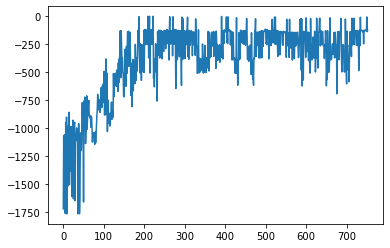

In [6]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [7]:
env.close()